In [9]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers


from tensorflow.keras.layers import Input


import pandas as pd
import datetime

data = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

In [10]:
def mean_absolute_percentage_error(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [11]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad

def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [12]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


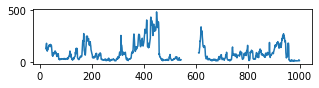

In [13]:
plt.figure(figsize=(5,1))
plt.plot(data['pm2.5'][:1000])

In [17]:
data['cbwd']=data['cbwd'].factorize()[0]

In [15]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [16]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,0,1.79,0,0
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,0,4.92,0,0
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,0,6.71,0,0
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,0,9.84,0,0
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,0,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,0,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,0,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,0,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,0,246.72,0,0


In [9]:
data.columns[5:]

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [10]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [11]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],scaled[train_size:,]
print(len(train),len(val), len(test),len(test1))

35059 4382 4383 8765


In [12]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

35035
4358
4359
8741


In [14]:
print(trainX.shape)
print(trainY.shape)

(35035, 24, 8)
(35035,)


## MTEX(1)



##참고

https://github.com/duyanhpham-brs/XAI-Multivariate-Time-Series/blob/develop/utils/training_helpers/__init__.py  

In [15]:
trainX = trainX.reshape(-1,24,8,1)
testX = testX.reshape(-1,24,8,1)
valX = valX.reshape(-1,24,8,1)

In [45]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/pm2.5_MTEX_onestep(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 8, 1)
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_10 (Reshape)         (None, 24, 8)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 24, 64)            1600      
_________________________________________________________________
flatten_10 (Flatten)         (None, 1536)

351/351 [==============================] - 2s 5ms/step - loss: 4.5488e-04 - val_loss: 5.0628e-04

Epoch 00040: val_loss did not improve from 0.00048
Epoch 41/200
351/351 [==============================] - 2s 6ms/step - loss: 4.5925e-04 - val_loss: 5.5509e-04

Epoch 00041: val_loss did not improve from 0.00048
Epoch 42/200
351/351 [==============================] - 2s 5ms/step - loss: 4.5647e-04 - val_loss: 5.0071e-04

Epoch 00042: val_loss did not improve from 0.00048
Epoch 43/200
351/351 [==============================] - 2s 6ms/step - loss: 4.4854e-04 - val_loss: 4.8969e-04

Epoch 00043: val_loss did not improve from 0.00048
Epoch 44/200
351/351 [==============================] - 2s 5ms/step - loss: 4.6874e-04 - val_loss: 4.7661e-04

Epoch 00044: val_loss did not improve from 0.00048
Epoch 45/200
351/351 [==============================] - 2s 6ms/step - loss: 4.5557e-04 - val_loss: 4.8951e-04

Epoch 00045: val_loss did not improve from 0.00048
Epoch 46/200
351/351 [===================

351/351 [==============================] - 3s 8ms/step - loss: 4.2436e-04 - val_loss: 4.8561e-04

Epoch 00138: val_loss did not improve from 0.00046
Epoch 139/200
351/351 [==============================] - 3s 8ms/step - loss: 4.2202e-04 - val_loss: 4.9508e-04

Epoch 00139: val_loss did not improve from 0.00046
Epoch 140/200
351/351 [==============================] - 3s 8ms/step - loss: 4.2703e-04 - val_loss: 4.6351e-04

Epoch 00140: val_loss did not improve from 0.00046
Epoch 141/200
351/351 [==============================] - 3s 8ms/step - loss: 4.2041e-04 - val_loss: 5.0166e-04

Epoch 00141: val_loss did not improve from 0.00046
Epoch 142/200
351/351 [==============================] - 3s 8ms/step - loss: 4.2504e-04 - val_loss: 4.8134e-04

Epoch 00142: val_loss did not improve from 0.00046
Epoch 143/200
351/351 [==============================] - 3s 8ms/step - loss: 4.2326e-04 - val_loss: 5.1293e-04

Epoch 00143: val_loss did not improve from 0.00046
Epoch 144/200
351/351 [=============

351/351 [==============================] - 2s 5ms/step - loss: 4.1263e-04 - val_loss: 4.8180e-04

Epoch 00188: val_loss did not improve from 0.00046
Epoch 189/200
351/351 [==============================] - 2s 5ms/step - loss: 4.1710e-04 - val_loss: 5.4515e-04

Epoch 00189: val_loss did not improve from 0.00046
Epoch 190/200
351/351 [==============================] - 2s 5ms/step - loss: 4.1848e-04 - val_loss: 5.1924e-04

Epoch 00190: val_loss did not improve from 0.00046
Epoch 191/200
351/351 [==============================] - 2s 5ms/step - loss: 4.1165e-04 - val_loss: 4.9160e-04

Epoch 00191: val_loss did not improve from 0.00046
Epoch 192/200
351/351 [==============================] - 2s 5ms/step - loss: 4.1105e-04 - val_loss: 5.4409e-04

Epoch 00192: val_loss did not improve from 0.00046
Epoch 193/200
351/351 [==============================] - 2s 5ms/step - loss: 4.1282e-04 - val_loss: 4.6090e-04

Epoch 00193: val_loss did not improve from 0.00046
Epoch 194/200
351/351 [=============

In [46]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep(1).hdf5")

In [47]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.091737814
Test RMSE : 0.01623673988802397
Test MAE : 0.00972863
Test MSE : 0.00026363172


## MTEX(2)

In [81]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/pm2.5_MTEX_onestep(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 8, 1)
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_21 (Reshape)         (None, 24, 8)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 24, 64)            1600      
_________________________________________________________________
flatten_21 (Flatten)         (None, 1536)

351/351 [==============================] - 2s 5ms/step - loss: 3.9974e-04 - val_loss: 5.2621e-04

Epoch 00088: val_loss did not improve from 0.00046
Epoch 89/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0254e-04 - val_loss: 4.6918e-04

Epoch 00089: val_loss did not improve from 0.00046
Epoch 90/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0330e-04 - val_loss: 4.7498e-04

Epoch 00090: val_loss did not improve from 0.00046
Epoch 91/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0042e-04 - val_loss: 4.7794e-04

Epoch 00091: val_loss did not improve from 0.00046
Epoch 92/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0389e-04 - val_loss: 4.7321e-04

Epoch 00092: val_loss did not improve from 0.00046
Epoch 93/200
351/351 [==============================] - 2s 5ms/step - loss: 3.9939e-04 - val_loss: 5.2000e-04

Epoch 00093: val_loss did not improve from 0.00046
Epoch 94/200
351/351 [===================

351/351 [==============================] - 2s 5ms/step - loss: 3.4504e-04 - val_loss: 5.0442e-04

Epoch 00188: val_loss did not improve from 0.00046
Epoch 189/200
351/351 [==============================] - 2s 5ms/step - loss: 3.2345e-04 - val_loss: 5.1159e-04

Epoch 00189: val_loss did not improve from 0.00046
Epoch 190/200
351/351 [==============================] - 2s 5ms/step - loss: 3.2096e-04 - val_loss: 5.4258e-04

Epoch 00190: val_loss did not improve from 0.00046
Epoch 191/200
351/351 [==============================] - 2s 5ms/step - loss: 3.2522e-04 - val_loss: 5.2377e-04

Epoch 00191: val_loss did not improve from 0.00046
Epoch 192/200
351/351 [==============================] - 2s 5ms/step - loss: 3.2646e-04 - val_loss: 5.1890e-04

Epoch 00192: val_loss did not improve from 0.00046
Epoch 193/200
351/351 [==============================] - 2s 5ms/step - loss: 3.2621e-04 - val_loss: 5.3669e-04

Epoch 00193: val_loss did not improve from 0.00046
Epoch 194/200
351/351 [=============

In [82]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep(2).hdf5")

In [83]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.09096285
Test RMSE : 0.01626645779573344
Test MAE : 0.009675136
Test MSE : 0.00026459765


## MTEX(3)

In [23]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/pm2.5_MTEX_onestep(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 8, 1)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_2 (Reshape)          (None, 24, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 64)            1600      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1536) 

351/351 [==============================] - 2s 5ms/step - loss: 3.9808e-04 - val_loss: 4.9185e-04

Epoch 00087: val_loss did not improve from 0.00046
Epoch 88/200
351/351 [==============================] - 2s 5ms/step - loss: 3.9939e-04 - val_loss: 4.9006e-04

Epoch 00088: val_loss did not improve from 0.00046
Epoch 89/200
351/351 [==============================] - 2s 5ms/step - loss: 3.9726e-04 - val_loss: 4.8045e-04

Epoch 00089: val_loss did not improve from 0.00046
Epoch 90/200
351/351 [==============================] - 2s 5ms/step - loss: 3.9461e-04 - val_loss: 4.6846e-04

Epoch 00090: val_loss did not improve from 0.00046
Epoch 91/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0304e-04 - val_loss: 4.9840e-04

Epoch 00091: val_loss did not improve from 0.00046
Epoch 92/200
351/351 [==============================] - 2s 5ms/step - loss: 3.9717e-04 - val_loss: 4.7802e-04

Epoch 00092: val_loss did not improve from 0.00046
Epoch 93/200
351/351 [===================

351/351 [==============================] - 2s 5ms/step - loss: 3.4178e-04 - val_loss: 6.1213e-04

Epoch 00187: val_loss did not improve from 0.00046
Epoch 188/200
351/351 [==============================] - 2s 5ms/step - loss: 3.3965e-04 - val_loss: 5.6348e-04

Epoch 00188: val_loss did not improve from 0.00046
Epoch 189/200
351/351 [==============================] - 2s 5ms/step - loss: 3.3311e-04 - val_loss: 5.8110e-04

Epoch 00189: val_loss did not improve from 0.00046
Epoch 190/200
351/351 [==============================] - 2s 5ms/step - loss: 3.3629e-04 - val_loss: 5.5480e-04

Epoch 00190: val_loss did not improve from 0.00046
Epoch 191/200
351/351 [==============================] - 2s 5ms/step - loss: 3.3661e-04 - val_loss: 5.8039e-04

Epoch 00191: val_loss did not improve from 0.00046
Epoch 192/200
351/351 [==============================] - 2s 5ms/step - loss: 3.3107e-04 - val_loss: 5.4809e-04

Epoch 00192: val_loss did not improve from 0.00046
Epoch 193/200
351/351 [=============

In [24]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep(3).hdf5")

In [25]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.09208754
Test RMSE : 0.016186156527645802
Test MAE : 0.00963871
Test MSE : 0.00026199166


## MTEX(4)

In [70]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/pm2.5_MTEX_onestep(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 8, 1)
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_17 (Reshape)         (None, 24, 8)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 24, 64)            1600      
_________________________________________________________________
flatten_17 (Flatten)         (None, 1536)


Epoch 00038: val_loss did not improve from 0.00047
Epoch 39/200
351/351 [==============================] - 2s 5ms/step - loss: 4.5519e-04 - val_loss: 4.8861e-04

Epoch 00039: val_loss did not improve from 0.00047
Epoch 40/200
351/351 [==============================] - 2s 5ms/step - loss: 4.4858e-04 - val_loss: 4.8159e-04

Epoch 00040: val_loss did not improve from 0.00047
Epoch 41/200
351/351 [==============================] - 2s 5ms/step - loss: 4.5849e-04 - val_loss: 4.7874e-04

Epoch 00041: val_loss did not improve from 0.00047
Epoch 42/200
351/351 [==============================] - 2s 5ms/step - loss: 4.5312e-04 - val_loss: 4.8736e-04

Epoch 00042: val_loss did not improve from 0.00047
Epoch 43/200
351/351 [==============================] - 2s 5ms/step - loss: 4.5282e-04 - val_loss: 4.9356e-04

Epoch 00043: val_loss did not improve from 0.00047
Epoch 44/200
351/351 [==============================] - 2s 5ms/step - loss: 4.4428e-04 - val_loss: 4.7077e-04

Epoch 00044: val_loss did n

351/351 [==============================] - 2s 5ms/step - loss: 4.2735e-04 - val_loss: 5.2778e-04

Epoch 00138: val_loss did not improve from 0.00047
Epoch 139/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2309e-04 - val_loss: 5.0834e-04

Epoch 00139: val_loss did not improve from 0.00047
Epoch 140/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2614e-04 - val_loss: 5.2894e-04

Epoch 00140: val_loss did not improve from 0.00047
Epoch 141/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2144e-04 - val_loss: 4.9668e-04

Epoch 00141: val_loss did not improve from 0.00047
Epoch 142/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2222e-04 - val_loss: 5.1478e-04

Epoch 00142: val_loss did not improve from 0.00047
Epoch 143/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2509e-04 - val_loss: 4.8231e-04

Epoch 00143: val_loss did not improve from 0.00047
Epoch 144/200
351/351 [=============

In [71]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep(4).hdf5")

In [72]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.08810179
Test RMSE : 0.01635667813446443
Test MAE : 0.009574468
Test MSE : 0.00026754092


## MTEX(5)

In [73]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/pm2.5_MTEX_onestep(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 8, 1)
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_18 (Reshape)         (None, 24, 8)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 24, 64)            1600      
_________________________________________________________________
flatten_18 (Flatten)         (None, 1536)

In [74]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep(5).hdf5")

In [56]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.089483604
Test RMSE : 0.01628819449030807
Test MAE : 0.009640668
Test MSE : 0.00026530528


## MTEX(6)

In [32]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/pm2.5_MTEX_onestep(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 8, 1)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_5 (Reshape)          (None, 24, 8)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 64)            1600      
_________________________________________________________________
flatten_5 (Flatten)          (None, 1536) 

351/351 [==============================] - 2s 5ms/step - loss: 3.5347e-04 - val_loss: 5.0482e-04

Epoch 00089: val_loss did not improve from 0.00047
Epoch 90/200
351/351 [==============================] - 2s 5ms/step - loss: 3.5367e-04 - val_loss: 5.4354e-04

Epoch 00090: val_loss did not improve from 0.00047
Epoch 91/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6239e-04 - val_loss: 5.2576e-04

Epoch 00091: val_loss did not improve from 0.00047
Epoch 92/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6981e-04 - val_loss: 5.2551e-04

Epoch 00092: val_loss did not improve from 0.00047
Epoch 93/200
351/351 [==============================] - 2s 5ms/step - loss: 3.5785e-04 - val_loss: 4.9457e-04

Epoch 00093: val_loss did not improve from 0.00047
Epoch 94/200
351/351 [==============================] - 2s 5ms/step - loss: 3.5874e-04 - val_loss: 5.1283e-04

Epoch 00094: val_loss did not improve from 0.00047
Epoch 95/200
351/351 [===================

351/351 [==============================] - 2s 5ms/step - loss: 2.9140e-04 - val_loss: 5.7376e-04

Epoch 00189: val_loss did not improve from 0.00047
Epoch 190/200
351/351 [==============================] - 2s 5ms/step - loss: 2.9013e-04 - val_loss: 5.6146e-04

Epoch 00190: val_loss did not improve from 0.00047
Epoch 191/200
351/351 [==============================] - 2s 5ms/step - loss: 2.8525e-04 - val_loss: 5.9161e-04

Epoch 00191: val_loss did not improve from 0.00047
Epoch 192/200
351/351 [==============================] - 2s 5ms/step - loss: 2.8523e-04 - val_loss: 5.7667e-04

Epoch 00192: val_loss did not improve from 0.00047
Epoch 193/200
351/351 [==============================] - 2s 5ms/step - loss: 2.8538e-04 - val_loss: 5.7510e-04

Epoch 00193: val_loss did not improve from 0.00047
Epoch 194/200
351/351 [==============================] - 2s 5ms/step - loss: 2.8559e-04 - val_loss: 5.8670e-04

Epoch 00194: val_loss did not improve from 0.00047
Epoch 195/200
351/351 [=============

In [57]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep(6).hdf5")

In [58]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.09344812
Test RMSE : 0.016348419096169443
Test MAE : 0.0098275915
Test MSE : 0.0002672708


## MTEX(7)

In [59]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/pm2.5_MTEX_onestep(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 8, 1)
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_14 (Reshape)         (None, 24, 8)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 24, 64)            1600      
_________________________________________________________________
flatten_14 (Flatten)         (None, 1536)

351/351 [==============================] - 2s 5ms/step - loss: 4.0979e-04 - val_loss: 4.6607e-04

Epoch 00088: val_loss did not improve from 0.00046
Epoch 89/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0776e-04 - val_loss: 4.7322e-04

Epoch 00089: val_loss did not improve from 0.00046
Epoch 90/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0784e-04 - val_loss: 4.7084e-04

Epoch 00090: val_loss did not improve from 0.00046
Epoch 91/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0664e-04 - val_loss: 4.7089e-04

Epoch 00091: val_loss did not improve from 0.00046
Epoch 92/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0880e-04 - val_loss: 5.0736e-04

Epoch 00092: val_loss did not improve from 0.00046
Epoch 93/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0736e-04 - val_loss: 4.9050e-04

Epoch 00093: val_loss did not improve from 0.00046
Epoch 94/200
351/351 [===================

351/351 [==============================] - 2s 5ms/step - loss: 3.5480e-04 - val_loss: 4.9108e-04

Epoch 00188: val_loss did not improve from 0.00046
Epoch 189/200
351/351 [==============================] - 2s 5ms/step - loss: 3.5210e-04 - val_loss: 4.9271e-04

Epoch 00189: val_loss did not improve from 0.00046
Epoch 190/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6254e-04 - val_loss: 4.8294e-04

Epoch 00190: val_loss did not improve from 0.00046
Epoch 191/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6266e-04 - val_loss: 5.0393e-04

Epoch 00191: val_loss did not improve from 0.00046
Epoch 192/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6730e-04 - val_loss: 4.9060e-04

Epoch 00192: val_loss did not improve from 0.00046
Epoch 193/200
351/351 [==============================] - 2s 5ms/step - loss: 4.0004e-04 - val_loss: 5.0352e-04

Epoch 00193: val_loss did not improve from 0.00046
Epoch 194/200
351/351 [=============

In [60]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep(7).hdf5")

In [61]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.094377674
Test RMSE : 0.01639501145570534
Test MAE : 0.009808216
Test MSE : 0.0002687964


## MTEX(8)

In [84]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/pm2.5_MTEX_onestep(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 8, 1)
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_22 (Reshape)         (None, 24, 8)             0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 24, 64)            1600      
_________________________________________________________________
flatten_22 (Flatten)         (None, 1536)


Epoch 00038: val_loss did not improve from 0.00047
Epoch 39/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2566e-04 - val_loss: 4.7150e-04

Epoch 00039: val_loss did not improve from 0.00047
Epoch 40/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2019e-04 - val_loss: 4.7362e-04

Epoch 00040: val_loss did not improve from 0.00047
Epoch 41/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2152e-04 - val_loss: 5.0177e-04

Epoch 00041: val_loss did not improve from 0.00047
Epoch 42/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2312e-04 - val_loss: 4.7988e-04

Epoch 00042: val_loss did not improve from 0.00047
Epoch 43/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2765e-04 - val_loss: 4.7461e-04

Epoch 00043: val_loss did not improve from 0.00047
Epoch 44/200
351/351 [==============================] - 2s 5ms/step - loss: 4.2008e-04 - val_loss: 4.7664e-04

Epoch 00044: val_loss did n

351/351 [==============================] - 2s 5ms/step - loss: 3.9237e-04 - val_loss: 4.9765e-04

Epoch 00089: val_loss did not improve from 0.00047
Epoch 90/200
351/351 [==============================] - 2s 5ms/step - loss: 3.9263e-04 - val_loss: 5.4129e-04

Epoch 00090: val_loss did not improve from 0.00047
Epoch 91/200
351/351 [==============================] - 2s 5ms/step - loss: 3.9072e-04 - val_loss: 5.1125e-04

Epoch 00091: val_loss did not improve from 0.00047
Epoch 92/200
351/351 [==============================] - 2s 5ms/step - loss: 3.8789e-04 - val_loss: 5.1860e-04

Epoch 00092: val_loss did not improve from 0.00047
Epoch 93/200
351/351 [==============================] - 2s 5ms/step - loss: 3.8919e-04 - val_loss: 5.4786e-04

Epoch 00093: val_loss did not improve from 0.00047
Epoch 94/200
351/351 [==============================] - 2s 5ms/step - loss: 3.8725e-04 - val_loss: 4.9376e-04

Epoch 00094: val_loss did not improve from 0.00047
Epoch 95/200
351/351 [===================

351/351 [==============================] - 2s 5ms/step - loss: 3.3338e-04 - val_loss: 6.0659e-04

Epoch 00189: val_loss did not improve from 0.00047
Epoch 190/200
351/351 [==============================] - 2s 5ms/step - loss: 3.3298e-04 - val_loss: 5.9747e-04

Epoch 00190: val_loss did not improve from 0.00047
Epoch 191/200
351/351 [==============================] - 2s 5ms/step - loss: 3.4017e-04 - val_loss: 6.2483e-04

Epoch 00191: val_loss did not improve from 0.00047
Epoch 192/200
351/351 [==============================] - 2s 5ms/step - loss: 3.2826e-04 - val_loss: 6.1211e-04

Epoch 00192: val_loss did not improve from 0.00047
Epoch 193/200
351/351 [==============================] - 2s 5ms/step - loss: 3.4059e-04 - val_loss: 6.4739e-04

Epoch 00193: val_loss did not improve from 0.00047
Epoch 194/200
351/351 [==============================] - 2s 5ms/step - loss: 3.2845e-04 - val_loss: 5.8408e-04

Epoch 00194: val_loss did not improve from 0.00047
Epoch 195/200
351/351 [=============

In [85]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep(8).hdf5")

In [86]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.09551396
Test RMSE : 0.01634924153847327
Test MAE : 0.009910924
Test MSE : 0.0002672977


## MTEX(9)

In [87]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/pm2.5_MTEX_onestep(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 8, 1)
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_23 (Reshape)         (None, 24, 8)             0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 24, 64)            1600      
_________________________________________________________________
flatten_23 (Flatten)         (None, 1536)

351/351 [==============================] - 2s 5ms/step - loss: 4.2529e-04 - val_loss: 4.8777e-04

Epoch 00038: val_loss did not improve from 0.00045
Epoch 39/200
351/351 [==============================] - 2s 5ms/step - loss: 4.1472e-04 - val_loss: 4.7890e-04

Epoch 00039: val_loss did not improve from 0.00045
Epoch 40/200
351/351 [==============================] - 2s 5ms/step - loss: 4.1884e-04 - val_loss: 4.6619e-04

Epoch 00040: val_loss did not improve from 0.00045
Epoch 41/200
351/351 [==============================] - 2s 5ms/step - loss: 4.1520e-04 - val_loss: 4.8866e-04

Epoch 00041: val_loss did not improve from 0.00045
Epoch 42/200
351/351 [==============================] - 2s 5ms/step - loss: 4.1622e-04 - val_loss: 4.9455e-04

Epoch 00042: val_loss did not improve from 0.00045
Epoch 43/200
351/351 [==============================] - 2s 5ms/step - loss: 4.1541e-04 - val_loss: 4.8651e-04

Epoch 00043: val_loss did not improve from 0.00045
Epoch 44/200
351/351 [===================


Epoch 00088: val_loss did not improve from 0.00045
Epoch 89/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6736e-04 - val_loss: 4.9172e-04

Epoch 00089: val_loss did not improve from 0.00045
Epoch 90/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6286e-04 - val_loss: 4.8249e-04

Epoch 00090: val_loss did not improve from 0.00045
Epoch 91/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6085e-04 - val_loss: 5.2077e-04

Epoch 00091: val_loss did not improve from 0.00045
Epoch 92/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6354e-04 - val_loss: 5.3280e-04

Epoch 00092: val_loss did not improve from 0.00045
Epoch 93/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6385e-04 - val_loss: 5.0074e-04

Epoch 00093: val_loss did not improve from 0.00045
Epoch 94/200
351/351 [==============================] - 2s 5ms/step - loss: 3.6655e-04 - val_loss: 4.8766e-04

Epoch 00094: val_loss did n

351/351 [==============================] - 2s 5ms/step - loss: 3.2764e-04 - val_loss: 5.2717e-04

Epoch 00139: val_loss did not improve from 0.00045
Epoch 140/200
351/351 [==============================] - 2s 5ms/step - loss: 3.1590e-04 - val_loss: 5.4616e-04

Epoch 00140: val_loss did not improve from 0.00045
Epoch 141/200
351/351 [==============================] - 2s 5ms/step - loss: 3.0837e-04 - val_loss: 5.5708e-04

Epoch 00141: val_loss did not improve from 0.00045
Epoch 142/200
351/351 [==============================] - 2s 5ms/step - loss: 3.1513e-04 - val_loss: 5.4944e-04

Epoch 00142: val_loss did not improve from 0.00045
Epoch 143/200
351/351 [==============================] - 2s 5ms/step - loss: 3.2639e-04 - val_loss: 5.5623e-04

Epoch 00143: val_loss did not improve from 0.00045
Epoch 144/200
351/351 [==============================] - 2s 5ms/step - loss: 3.1257e-04 - val_loss: 5.4542e-04

Epoch 00144: val_loss did not improve from 0.00045
Epoch 145/200
351/351 [=============

In [88]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep(9).hdf5")

In [89]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.093273625
Test RMSE : 0.016222644974743447
Test MAE : 0.009775244
Test MSE : 0.0002631742


## MTEX(10)

In [64]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/pm2.5_MTEX_onestep(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 8, 1)
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 24, 8, 1)]        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_15 (Reshape)         (None, 24, 8)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 24, 64)            1600      
_________________________________________________________________
flatten_15 (Flatten)         (None, 1536)


Epoch 00038: val_loss did not improve from 0.00046
Epoch 39/200
351/351 [==============================] - 3s 8ms/step - loss: 4.2188e-04 - val_loss: 4.8919e-04

Epoch 00039: val_loss did not improve from 0.00046
Epoch 40/200
351/351 [==============================] - 3s 8ms/step - loss: 4.2878e-04 - val_loss: 4.5831e-04

Epoch 00040: val_loss improved from 0.00046 to 0.00046, saving model to saved_weights/pm2.5_MTEX_onestep(10).hdf5
Epoch 41/200
351/351 [==============================] - 3s 8ms/step - loss: 4.2635e-04 - val_loss: 4.5810e-04

Epoch 00041: val_loss improved from 0.00046 to 0.00046, saving model to saved_weights/pm2.5_MTEX_onestep(10).hdf5
Epoch 42/200
351/351 [==============================] - 3s 8ms/step - loss: 4.2738e-04 - val_loss: 4.7356e-04

Epoch 00042: val_loss did not improve from 0.00046
Epoch 43/200
351/351 [==============================] - 3s 8ms/step - loss: 4.3013e-04 - val_loss: 4.6791e-04

Epoch 00043: val_loss did not improve from 0.00046
Epoch 44/200

351/351 [==============================] - 3s 8ms/step - loss: 3.5832e-04 - val_loss: 5.3394e-04

Epoch 00138: val_loss did not improve from 0.00046
Epoch 139/200
351/351 [==============================] - 3s 8ms/step - loss: 3.5561e-04 - val_loss: 5.4260e-04

Epoch 00139: val_loss did not improve from 0.00046
Epoch 140/200
351/351 [==============================] - 3s 8ms/step - loss: 3.5828e-04 - val_loss: 5.7633e-04

Epoch 00140: val_loss did not improve from 0.00046
Epoch 141/200
351/351 [==============================] - 3s 8ms/step - loss: 3.5250e-04 - val_loss: 5.8589e-04

Epoch 00141: val_loss did not improve from 0.00046
Epoch 142/200
351/351 [==============================] - 2s 7ms/step - loss: 3.5731e-04 - val_loss: 5.3944e-04

Epoch 00142: val_loss did not improve from 0.00046
Epoch 143/200
351/351 [==============================] - 3s 8ms/step - loss: 3.5559e-04 - val_loss: 5.6725e-04

Epoch 00143: val_loss did not improve from 0.00046
Epoch 144/200
351/351 [=============

In [65]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep(10).hdf5")

In [66]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.08670434
Test RMSE : 0.01633142426573359
Test MAE : 0.009622687
Test MSE : 0.00026671542


In [ ]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])